#### Imported Libraries:

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import random

from sklearn.model_selection import train_test_split

##### constants:

In [82]:
img_height = 200
img_width = 200

#### Load Data

In [79]:
def resize_without_squeezing(image, target_size):
    h, w = image.shape[:2]
    aspect_ratio = w / h

    # Calculate new size while preserving aspect ratio
    if aspect_ratio > 1:
        new_w = target_size
        new_h = int(target_size / aspect_ratio)
    else:
        new_h = target_size
        new_w = int(target_size * aspect_ratio)

    # Resize the image
    resized_img = cv2.resize(image, (new_w, new_h))

    # Create a canvas with the target size and fill with padding color
    canvas = np.full((target_size, target_size, 3), (255,255,255), dtype=np.uint8)

    # Calculate the position to paste the resized image in the center
    y_offset = (target_size - new_h) // 2
    x_offset = (target_size - new_w) // 2

    # Paste the resized image onto the canvas
    canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_img

    return canvas

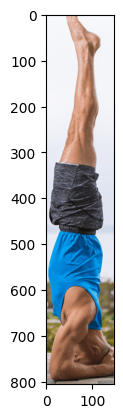

In [80]:
img = cv2.imread("../data/dataset/salamba sirsasana/55-0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
#img = cv2.resize(img, (100, 100))
plt.imshow(img)
plt.show()

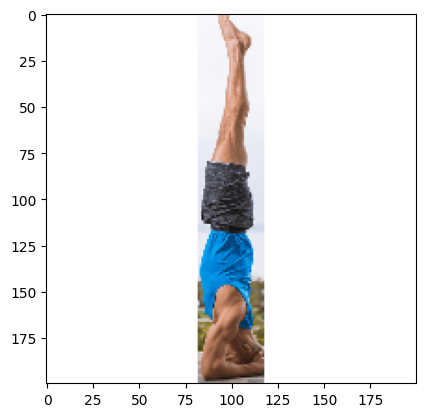

In [83]:
img = cv2.imread("../data/dataset/salamba sirsasana/55-0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
img = resize_without_squeezing(img,img_height)
plt.imshow(img)
plt.show()

In [84]:
def get_folders_in_directory(directory_path):
    # Get the list of all files and folders in the specified directory
    items = os.listdir(directory_path)
    # Filter out only the folders from the list
    folders = [item for item in items if os.path.isdir(os.path.join(directory_path, item))]
    return folders
    
def load_images_from_folder(folder):
    # Function to load and preprocess images from a folder
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            # img = resize_without_squeezing(img,img_height)
            img = cv2.resize(img, (img_height, img_width))
            images.append(img)
    return images




base_dir = '../data/dataset'
labels_name = get_folders_in_directory(base_dir) # get the list of folder names
labels_dict = {label:i for i,label in enumerate(labels_name)} # assign an int for each folder name = asana

# Get all images and corresp labels
all_images=[]
all_labels=[]
for label in labels_name:
    new_images = load_images_from_folder(base_dir+'/'+label)
    all_images = all_images + new_images
    for i in range(len(new_images)):
        all_labels.append(labels_dict[label])

# Ensure that all_image_paths and all_labels are numpy arrays for easier manipulation
images = np.array(all_images)/255 # color values btw 0-1
labels = np.array(all_labels)

MemoryError: Unable to allocate 686. MiB for an array with shape (5992, 200, 200, 3) and data type uint8

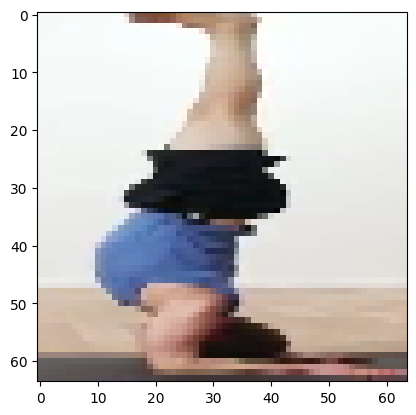

In [61]:
img = all_images[102]
plt.imshow(img)
plt.show()

#### Split Data into train, validation, and test sets

In [56]:
# SPLITTING
# Split the dataset into training and temporary sets (combined validation and test)
train_data, temp_data, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)
# Split the temporary set into validation and test sets
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42
)

MemoryError: Unable to allocate 393. MiB for an array with shape (4194, 64, 64, 3) and data type float64

In [ ]:
from tensorflow.keras.utils import to_categorical

# For multi-class classification
train_labels_one_hot = to_categorical(train_labels, num_classes=107)
val_labels_one_hot = to_categorical(val_labels, num_classes=107)
test_labels_one_hot = to_categorical(test_labels, num_classes=107)

#### Inicialize ImageDataGenerator

In [ ]:
# Create an ImageDataGenerator for data augmentation
def add_noise(img):
    #Add random noise to an image
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    new_img = img + noise
    np.clip(new_img, 0., 255.)
    return new_img
    
# Initialising the ImageDataGenerator class.
# We will pass in the augmentation parameters in the constructor.
datagen = ImageDataGenerator(
        rotation_range = 360,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip = True,
        vertical_flip = True,
        preprocessing_function=add_noise
)

#### Create Model

In [ ]:
# Define your CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    #layers.Dense(512, activation='relu'),
    layers.Dense(107, activation='softmax') 
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Train Model

In [46]:
# Train the model with data augmentation
batch_size = 32 # number of training examples utilized in one iteration
# Use flow for the training set
train_datagen = datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size)
# Use flow for the validation set
val_datagen = datagen.flow(val_data, val_labels_one_hot, batch_size=batch_size)

# Train the model with data augmentation
history = model.fit(train_datagen, epochs=10, validation_data=val_datagen)


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data, test_labels_one_hot)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
132/132 [==============================] - 7s 56ms/step - loss: 4.6607 - accuracy: 0.0148 - val_loss: 4.6613 - val_accuracy: 0.0133
Epoch 2/10
132/132 [==============================] - 8s 57ms/step - loss: 4.6575 - accuracy: 0.0150 - val_loss: 4.6590 - val_accuracy: 0.0133
Epoch 3/10
132/132 [==============================] - 8s 58ms/step - loss: 4.6555 - accuracy: 0.0153 - val_loss: 4.6561 - val_accuracy: 0.0167
Epoch 4/10
132/132 [==============================] - 8s 58ms/step - loss: 4.6541 - accuracy: 0.0145 - val_loss: 4.6575 - val_accuracy: 0.0122
Epoch 5/10
132/132 [==============================] - 8s 62ms/step - loss: 4.6523 - accuracy: 0.0155 - val_loss: 4.6567 - val_accuracy: 0.0133
Epoch 6/10
132/132 [==============================] - 10s 76ms/step - loss: 4.6510 - accuracy: 0.0150 - val_loss: 4.6561 - val_accuracy: 0.0133
Epoch 7/10
132/132 [==============================] - 8s 64ms/step - loss: 4.6498 - accuracy: 0.0138 - val_loss: 4.6557 - val_accuracy: 0.013

In [ ]:
# (64,64,3)
# 1 layer, 4 epochs, batch_size 8 : Test accuracy: 0.01001112349331379
# 2 layers, 4 epochs, batch_size 8 : Test accuracy: 0.01001112349331379
# 3 layers, 4 epochs, batch_size 8 : Test accuracy: 0.01446051150560379
# 3 layers, 4 epochs, batch_size 32 : Test accuracy: 0.013348164968192577
# 3 layers, 10 epochs, batch_size 32 : Test accuracy: 0.013348164968192577


#### Ways to improve the model:
- tune hyperparameters
- decide number of layers

##### Hyperparameters:
1. number of neurons in each hidden layer: The number of neurons should be adjusted to the solution complexity. The task with a more complex level to predict needs more neurons. The number of neurons range is set to be from 10 to 100.
pu
2activation function: is a parameter in each layer. 

##### Number of layers:
(different layers can affect the accuracy. fewer layers may give an underfitting result while too many layers may make it overfitting)